**Reference**: 

`Using_RNNs_and_LSTMs` 
    https://colab.research.google.com/drive/1G6bxy1OlHPeVo6zAs8TxvN5du9PHhZQf?usp=sharing
        
`Deep_Learning_with_Word_Embeddings`
    https://colab.research.google.com/drive/1CtQr7n6zp_mDJYpXNRSc3Fqg1JGqN194?usp=sharing

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.filterwarnings("ignore", category=VisibleDeprecationWarning)

In [2]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
from typing import Dict
from matplotlib import pyplot as plt

import spacy
from textacy.preprocessing.replace import urls, hashtags, numbers, emails, emojis, currency_symbols
from textacy.preprocessing.remove import punctuation
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Masking
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.layers.recurrent import SimpleRNN, LSTM

from clr import LRFinder, OneCycleLR

Using TensorFlow backend.


In [3]:
data = pd.read_csv('./Data/steam_cleaned_v2.csv', index_col=0, na_filter=False)
data['label'] = pd.to_numeric(data['label'])
docs_cleaned = data['review'].tolist()
labels = data['label']

In [4]:
data

,review,label
0,Great Game terrible Hopefully fix instead tryi...,0
1,Huh actually don t like ve ed game Edmund ve f...,0
2,trashy talking le,0
3,Lag shit,0
4,policies,0
...,...,...
64244,good game like,1
64245,runs super streamlined,1
64246,like game iot gun b,1
64247,Bought 3rd time PC normal legendary edition pi...,1


# data tokenization

<AxesSubplot:>

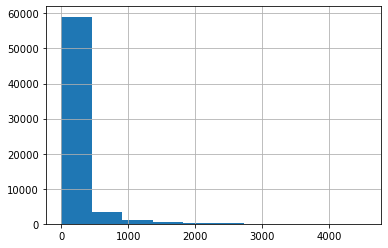

In [5]:
pd.Series(docs_cleaned).str.len().hist()

In [6]:
pd.Series(docs_cleaned).str.len().describe()

count    64249.000000
mean       155.854146
std        321.142423
min          0.000000
25%         17.000000
50%         51.000000
75%        153.000000
max       4544.000000
dtype: float64

 > since 75% of the reviews are less than 153 words, set `MAX_SEQUENCE_LENGTH` to 150

In [7]:
MAX_SEQUENCE_LENGTH = 150

In [8]:
tokenizer = Tokenizer(num_words=5000, oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts(docs_cleaned)

In [9]:
def integer_encode_documents(docs, tokenizer):
    return tokenizer.texts_to_sequences(docs)

In [10]:
# integer encode the documents
docs_encoded = integer_encode_documents(docs_cleaned, tokenizer)

In [11]:
np.array(docs_encoded).shape

/Users/antheayang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


(64249,)

In [12]:
docs_padded = pad_sequences(docs_encoded, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
docs_padded

array([[  12,    2,  167, ...,    0,    0,    0],
       [3647,   54,   11, ...,    0,    0,    0],
       [   1,  700, 3881, ...,    0,    0,    0],
       ...,
       [   5,    2,    1, ...,    0,    0,    0],
       [ 108, 1350,    9, ...,    0,    0,    0],
       [ 438,    7,    2, ...,    0,    0,    0]], dtype=int32)

In [13]:
docs_padded.shape

(64249, 150)

In [14]:
vocab_size = int(len(tokenizer.word_index) * 1.3)
print(f"Vocab size is {vocab_size} unique tokens.")

Vocab size is 27757 unique tokens.


In [15]:
data_docs_padded = pd.DataFrame(docs_padded)
data_docs_padded

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,12,2,167,942,72,117,104,540,699,0,...,0,0,0,0,0,0,0,0,0,0
1,3647,54,11,4,5,16,3284,2,1,16,...,0,0,0,0,0,0,0,0,0,0
2,1,700,3881,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,308,69,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3593,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64244,7,2,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64245,298,217,4294,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64246,5,2,1,394,82,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64247,108,1350,9,85,555,1875,534,1,2466,170,...,0,0,0,0,0,0,0,0,0,0


In [16]:
data_docs_padded = pd.concat([data_docs_padded.reset_index(drop=True),
                              data.reset_index(drop=True)], axis=1, ignore_index=True)

In [17]:
data_docs_padded

,0,1,2,3,4,5,6,7,8,9,...,142,143,144,145,146,147,148,149,150,151
0,12,2,167,942,72,117,104,540,699,0,...,0,0,0,0,0,0,0,0,Great Game terrible Hopefully fix instead tryi...,0
1,3647,54,11,4,5,16,3284,2,1,16,...,0,0,0,0,0,0,0,0,Huh actually don t like ve ed game Edmund ve f...,0
2,1,700,3881,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,trashy talking le,0
3,308,69,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Lag shit,0
4,3593,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,policies,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64244,7,2,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,good game like,1
64245,298,217,4294,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,runs super streamlined,1
64246,5,2,1,394,82,0,0,0,0,0,...,0,0,0,0,0,0,0,0,like game iot gun b,1
64247,108,1350,9,85,555,1875,534,1,2466,170,...,0,0,0,0,0,0,0,0,Bought 3rd time PC normal legendary edition pi...,1


In [18]:
mp = {data_docs_padded.columns[-1]: 'label',
     data_docs_padded.columns[-2]: 'text'}
data_docs_padded.rename(columns=mp, errors="raise", inplace=True)
data_docs_padded.columns[-3:]

Index([149, 'text', 'label'], dtype='object')

In [19]:
# data_docs_padded.to_csv('./Data/steam_docs_padded.csv')

In [20]:
X_train, X_test, y_train, y_test = train_test_split(docs_padded, labels, 
                                                    test_size=0.2, random_state=41)
X_train.shape, X_test.shape

((51399, 150), (12850, 150))

# model

In [61]:
def plot_fit_history(log):
    plt.plot(log.history['acc'])
    plt.plot(log.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

## RNN

### pretrained embedding

In [70]:
def load_glove_vectors() -> Dict:
    embeddings_index = {}
    with open('../datasets/glove.6B.100d.txt') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index

embeddings_index = load_glove_vectors()

Loaded 400000 word vectors.


In [71]:
vocab_size

27766

In [72]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # check that it is an actual word that we have embeddings for
        embedding_matrix[i] = embedding_vector

In [73]:
# define model
def make_binary_classification_rnn_model(plot=False):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, 
                        weights=[embedding_matrix], 
                        input_length=MAX_SEQUENCE_LENGTH, 
                        trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(SimpleRNN(units=64, input_shape=(1, MAX_SEQUENCE_LENGTH)))
    model.add(Dense(16))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(
            optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [74]:
model_rnn = make_binary_classification_rnn_model()
model_rnn

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 150, 100)          2776600   
_________________________________________________________________
masking_1 (Masking)          (None, 150, 100)          0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                10560     
_________________________________________________________________
dense_7 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 2,788,217
Trainable params: 11,617
Non-trainable params: 2,776,600
_________________________________________________________________


### training

In [75]:
# fit the model
es = EarlyStopping(monitor='val_loss', mode='min', patience=4, verbose=1)
log_rnn = model_rnn.fit(X_train, y_train, batch_size=BATCH_SIZE, 
                        validation_split=0.1, epochs=50, verbose=1, callbacks=[es])

Train on 46259 samples, validate on 5140 samples
Epoch 1/50
46259/46259 [==============================] - 162s 3ms/step - loss: 0.5251 - acc: 0.7413 - val_loss: 0.5015 - val_acc: 0.7533
Epoch 2/50
46259/46259 [==============================] - 161s 3ms/step - loss: 0.5110 - acc: 0.7528 - val_loss: 0.5073 - val_acc: 0.7553
Epoch 3/50
46259/46259 [==============================] - 157s 3ms/step - loss: 0.5101 - acc: 0.7561 - val_loss: 0.5054 - val_acc: 0.7541
Epoch 4/50
46259/46259 [==============================] - 158s 3ms/step - loss: 0.4901 - acc: 0.7639 - val_loss: 0.4995 - val_acc: 0.7588
Epoch 5/50
46259/46259 [==============================] - 157s 3ms/step - loss: 0.4714 - acc: 0.7757 - val_loss: 0.4783 - val_acc: 0.7673
Epoch 6/50
46259/46259 [==============================] - 157s 3ms/step - loss: 0.4750 - acc: 0.7780 - val_loss: 0.4866 - val_acc: 0.7603
Epoch 7/50
46259/46259 [==============================] - 157s 3ms/step - loss: 0.4703 - acc: 0.7762 - val_loss: 0.4841 - v

In [76]:
# evaluate the model
loss_tr, acc_tr = model_rnn.evaluate(X_train, y_train, verbose=1)
print('TRAIN Accuracy: %f' % (acc_tr*100))

51399/51399 [==============================] - 91s 2ms/step
TRAIN Accuracy: 79.260296


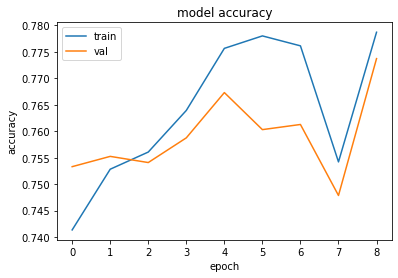

In [77]:
plot_fit_history(log_rnn)

### testing

In [78]:
loss_tt, acc_tt = model_rnn.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (acc_tt*100))

12850/12850 [==============================] - 23s 2ms/step
Accuracy: 77.719843


### model result

In [81]:
pred_rnn = model_rnn.predict(docs_padded)

In [82]:
pred_rnn = pred_rnn.flatten()
pred_rnn

array([0.31658024, 0.15784225, 0.6243247 , ..., 0.76593053, 0.5849264 ,
       0.93743324], dtype=float32)

In [83]:
threshold = .5
data_docs_padded['pred_rnn'] = np.where(pred_rnn>=threshold, 1, 0)

In [84]:
sum(data_docs_padded['pred_rnn']==data_docs_padded['label']) / len(data_docs_padded)

0.7895220159068623

## LSTM

In [85]:
def make_lstm_classification_model(plot=False):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, 
                        weights=[embedding_matrix], 
                        input_length=MAX_SEQUENCE_LENGTH, 
                        trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(LSTM(units=32, input_shape=(1, MAX_SEQUENCE_LENGTH)))
    model.add(Dense(16))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(
            optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [86]:
model_lstm = make_lstm_classification_model()
model_lstm

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 150, 100)          2776600   
_________________________________________________________________
masking_2 (Masking)          (None, 150, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 17        
Total params: 2,794,169
Trainable params: 17,569
Non-trainable params: 2,776,600
_________________________________________________________________


### training

In [87]:
# fit the model
es = EarlyStopping(monitor='val_loss', mode='min', patience=4, verbose=1)
log_lstm = model_lstm.fit(X_train, y_train, batch_size=BATCH_SIZE, 
                        validation_split=0.1, epochs=50, verbose=1, callbacks=[es])

Train on 46259 samples, validate on 5140 samples
Epoch 1/50
46259/46259 [==============================] - 219s 5ms/step - loss: 0.4863 - acc: 0.7633 - val_loss: 0.4892 - val_acc: 0.7549
Epoch 2/50
46259/46259 [==============================] - 217s 5ms/step - loss: 0.4314 - acc: 0.7957 - val_loss: 0.4584 - val_acc: 0.7774
Epoch 3/50
46259/46259 [==============================] - 217s 5ms/step - loss: 0.4092 - acc: 0.8094 - val_loss: 0.4251 - val_acc: 0.7951
Epoch 4/50
46259/46259 [==============================] - 218s 5ms/step - loss: 0.3934 - acc: 0.8178 - val_loss: 0.4240 - val_acc: 0.7979
Epoch 5/50
46259/46259 [==============================] - 217s 5ms/step - loss: 0.3803 - acc: 0.8243 - val_loss: 0.4151 - val_acc: 0.8072
Epoch 6/50
46259/46259 [==============================] - 218s 5ms/step - loss: 0.3691 - acc: 0.8324 - val_loss: 0.4116 - val_acc: 0.8084
Epoch 7/50
46259/46259 [==============================] - 218s 5ms/step - loss: 0.3593 - acc: 0.8363 - val_loss: 0.4095 - v

In [88]:
# evaluate the model
loss_tr, acc_tr = model_lstm.evaluate(X_train, y_train, verbose=1)
print('TRAIN Accuracy: %f' % (acc_tr*100))

51399/51399 [==============================] - 127s 2ms/step
TRAIN Accuracy: 86.314911


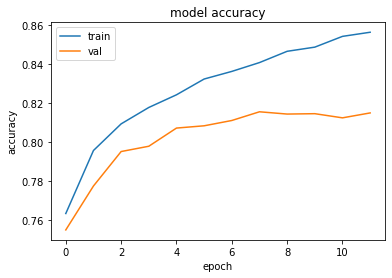

In [89]:
plot_fit_history(log_lstm)

### testing

In [90]:
loss_tt, acc_tt = model_lstm.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (acc_tt*100))

12850/12850 [==============================] - 32s 3ms/step
Accuracy: 81.447470


### model_result

In [91]:
pred_lstm = model_lstm.predict(docs_padded)
pred_lstm = pred_lstm.flatten()
pred_lstm

array([0.0122683 , 0.20635751, 0.09764171, ..., 0.8674997 , 0.82471275,
       0.9808508 ], dtype=float32)

In [92]:
threshold = .5
data_docs_padded['pred_lstm'] = np.where(pred_lstm>=threshold, 1, 0)

In [93]:
sum(data_docs_padded['pred_lstm']==data_docs_padded['label']) / len(data_docs_padded)

0.8534140609192361

# results

In [94]:
data_docs_padded

,0,1,2,3,4,5,6,7,8,9,...,145,146,147,148,149,text,label,pred_mlp,pred_rnn,pred_lstm
0,12,2,167,941,72,117,104,540,700,0,...,0,0,0,0,0,Great Game terrible optimisation Hopefully the...,0.0,0,0,0
1,3651,54,11,4,5,16,3285,2,1,16,...,0,0,0,0,0,Huh I actually don t like it I ve NUMBER ed e...,0.0,0,0,0
2,1,701,3829,0,0,0,0,0,0,0,...,0,0,0,0,0,very trashy talking about the tsev skyrim le,0.0,0,1,0
3,308,69,0,0,0,0,0,0,0,0,...,0,0,0,0,0,Lag as shit,0.0,0,0,0
4,3598,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,Precarious policies,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64244,7,2,5,0,0,0,0,0,0,0,...,0,0,0,0,0,good game i like it,1.0,1,1,1
64245,298,217,4297,0,0,0,0,0,0,0,...,0,0,0,0,0,It just runs really well and is super streamli...,1.0,1,1,1
64246,5,2,1,393,82,0,0,0,0,0,...,0,0,0,0,0,I like tthis game iot have gun and it have a b,1.0,1,1,1
64247,108,1353,9,86,555,1879,537,1,2468,171,...,0,0,0,0,0,Bought it again for the 3rd time on PC had nor...,1.0,1,1,1


In [95]:
data_docs_padded.to_csv('./Data/model_preds.csv')